In [1]:
import torchvision.models as models
import torch
import torch.onnx
from torchvision.models import ResNet50_Weights

# load the pretrained model
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1, progress=False).eval()

In [2]:
BATCH_SIZE=32

dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)

In [3]:
torch.onnx.export(resnet50, dummy_input, "resnet50_pytorch.onnx", verbose=False)

In [4]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
img = np.expand_dims(np.array(img, dtype=np.float32), axis=0) # Expand image to have a batch dimension
input_batch = np.array(np.repeat(img, BATCH_SIZE, axis=0), dtype=np.float32) # Repeat across the batch dimension

input_batch.shape

(32, 224, 224, 3)

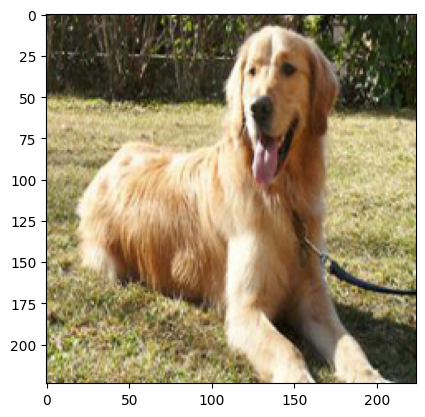

In [5]:
plt.imshow(input_batch[0].astype(np.float32))

In [6]:
resnet50_gpu = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1, progress=False).to("cuda").eval()

In [7]:
input_batch_chw = torch.from_numpy(input_batch).transpose(1,3).transpose(2,3)
input_batch_gpu = input_batch_chw.to("cuda")

input_batch_gpu.shape

torch.Size([32, 3, 224, 224])

In [8]:
with torch.no_grad():
    predictions = np.array(resnet50_gpu(input_batch_gpu).cpu())

predictions.shape

(32, 1000)

In [9]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu(input_batch_gpu).cpu())

28.4 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
resnet50_gpu_half = resnet50_gpu.half()
input_half = input_batch_gpu.half()

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu()) # Warm Up
    
preds.shape

(32, 1000)

In [11]:
%%timeit

with torch.no_grad():
    preds = np.array(resnet50_gpu_half(input_half).cpu())

12.2 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
indices = (-predictions[0]).argsort()[:5]
print("Class | Likelihood")
list(zip(indices, predictions[0][indices]))

Class | Likelihood


[(207, 13.220737),
 (208, 9.577336),
 (257, 9.264831),
 (205, 8.896545),
 (256, 8.567412)]

In [ ]:
import os

os._exit(0) # Shut down all kernels so TRT doesn't fight with PyTorch for GPU memory

: 

: 

In [1]:
BATCH_SIZE = 32

In [2]:
import numpy as np

USE_FP16 = True
target_dtype = np.float16 if USE_FP16 else np.float32

In [3]:
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np

url='https://images.dog.ceo/breeds/retriever-golden/n02099601_3004.jpg'
img = resize(io.imread(url), (224, 224))
input_batch = np.array(np.repeat(np.expand_dims(np.array(img, dtype=np.float32), axis=0), BATCH_SIZE, axis=0), dtype=np.float32)

input_batch.shape

(32, 224, 224, 3)

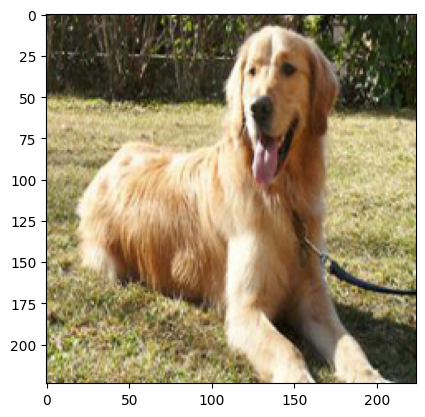

In [4]:
plt.imshow(input_batch[0].astype(np.float32))

In [5]:
import torch
from torchvision.transforms import Normalize

def preprocess_image(img):
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    result = norm(torch.from_numpy(img).transpose(0,2).transpose(1,2))
    return np.array(result, dtype=np.float16)

preprocessed_images = np.array([preprocess_image(image) for image in input_batch])

In [6]:
torch.cuda.is_available()

True

In [1]:
import tensorrt

FileNotFoundError: Could not find: nvinfer.dll. Is it on your PATH?
Note: Paths searched were:
['c:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt\\Library\\mingw-w64\\bin', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt\\Library\\usr\\bin', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt\\Library\\bin', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt\\Scripts', 'C:\\Users\\devLupin\\Miniconda3\\envs\\tensorrt\\bin', 'C:\\Users\\devLupin\\miniconda3\\condabin', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.3\\bin', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.3\\libnvvp', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\bin', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\libnvvp', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.1\\bin', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.1\\libnvvp', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin', 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\libnvvp', 'C:\\Windows\\system32', 'C:\\Windows', 'C:\\Windows\\System32\\Wbem', 'C:\\Windows\\System32\\WindowsPowerShell\\v1.0', 'C:\\Windows\\System32\\OpenSSH', 'C:\\Program Files\\Bandizip', 'C:\\Program Files\\Git\\cmd', 'C:\\Users\\devLupin\\Miniconda3', 'C:\\Users\\devLupin\\Miniconda3\\Scripts', 'C:\\Users\\devLupin\\Miniconda3\\Library\\bin', 'C:\\Program Files\\nodejs', 'C:\\Windows\\System32\\OpenSSH', 'C:\\opencv\\build\\x64\\vc15\\bin', 'C:\\MinGW\\bin', 'C:\\Ruby31-x64\\bin', 'C:\\Users\\devLupin\\miniconda3', 'C:\\Users\\devLupin\\miniconda3\\Library\\mingw-w64\\bin', 'C:\\Users\\devLupin\\miniconda3\\Library\\usr\\bin', 'C:\\Users\\devLupin\\miniconda3\\Library\\bin', 'C:\\Users\\devLupin\\miniconda3\\Scripts', 'C:\\Users\\devLupin\\anaconda3', 'C:\\Users\\devLupin\\anaconda3\\Library\\mingw-w64\\bin', 'C:\\Users\\devLupin\\anaconda3\\Library\\usr\\bin', 'C:\\Users\\devLupin\\anaconda3\\Library\\bin', 'C:\\Users\\devLupin\\anaconda3\\Scripts', 'C:\\Program Files\\MySQL\\MySQL Shell 8.0\\bin', 'C:\\Users\\devLupin\\AppData\\Local\\Microsoft\\WindowsApps', 'C:\\Program Files\\Microsoft VS Code\\bin', 'C:\\Users\\devLupin\\AppData\\Roaming\\npm', 'C:\\mingw64\\bin', 'C:\\ffmpeg\\bin', '.']

In [ ]:
# step out of Python for a moment to convert the ONNX model to a TRT engine using trtexec
if USE_FP16:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
else:
    !trtexec --onnx=resnet50_pytorch.onnx --saveEngine=resnet_engine_pytorch.trt  --explicitBatch